In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
import requests
import itertools
import geopandas as gpd

from shapely.geometry import Point
import json

from io import StringIO

In [2]:
from utils import (
    add_time_lags,
    add_seasonal_anomalies,
    add_rolling_means,
    add_rolling_anomalies,
    add_rolling_lag_means
)

In [3]:
home = 'C:\\Users\\ck24\\OneDrive - University of Illinois - Urbana\\Documents\\geospatial_data_collection'

In [8]:
from dotenv import load_dotenv

# Load from .env
load_dotenv(dotenv_path=home+r"\acled_key.env")

# Access the keys
acled_id = os.getenv("ACLED_ID")
acled_key = os.getenv("ACLED_KEY")

In [9]:
# Original dictionary
numeric_country_codes = {
    'Afghanistan': '004',
    'Bangladesh': '050',
    'Pakistan': '586',
    'Timor_Leste': '626',
    'Burundi': '108',
    'Central_African_Republic': '140',
    'Congo_DRC': '180',
    'Djibouti': '262',
    'Ethiopia': '231',
    'Kenya': '404',
    'Somalia': '706',
    'South_Sudan': '728',
    'Sudan': '729',
    'Tanzania': '834',
    'Uganda': '800',
    'Angola': '024',
    'Eswatini': '748',
    'Lesotho': '426',
    'Nigeria': '566',
    'Ethiopia': '231',
    'Madagascar': '450',
    'Malawi': '454',
    'Mozambique': '508',
    'Namibia': '516',
    'South_Africa': '710',
    'Zambia': '894',
    'Zimbabwe': '716',
    'Dominican_Republic': '214',
    'El_Salvador': '222',
    'Guatemala': '320',
    'Haiti': '332',
    'Honduras': '340',
    'Lebanon': '422',
    'Yemen': '887',
}

# Inverting the dictionary
code_to_country = {v: k for k, v in numeric_country_codes.items()}

# Now, if you have a list of sorted numeric codes and you want to print their corresponding country names
iso_num_code = sorted([code for code in numeric_country_codes.values() if code is not None])

# To find and print country names for each code
for code in iso_num_code:
    country = code_to_country[code]
    print(f"{code}: {country}")


004: Afghanistan
024: Angola
050: Bangladesh
108: Burundi
140: Central_African_Republic
180: Congo_DRC
214: Dominican_Republic
222: El_Salvador
231: Ethiopia
262: Djibouti
320: Guatemala
332: Haiti
340: Honduras
404: Kenya
422: Lebanon
426: Lesotho
450: Madagascar
454: Malawi
508: Mozambique
516: Namibia
566: Nigeria
586: Pakistan
626: Timor_Leste
706: Somalia
710: South_Africa
716: Zimbabwe
728: South_Sudan
729: Sudan
748: Eswatini
800: Uganda
834: Tanzania
887: Yemen
894: Zambia


# Retrieve ACLED data from API

In [10]:
#Skip

In [11]:
list_of_countries = sorted(['Madagascar', 'Haiti', 'Yemen', 'South_Sudan', 'Congo_DRC',
       'Afghanistan', 'Ethiopia', 'Central_African_Republic', 'Djibouti', 'Pakistan',
       'Mozambique', 'Lebanon', 'Kenya', 'Guatemala', 'Sudan','Nigeria','Malawi'])

list_of_countries

['Afghanistan',
 'Central_African_Republic',
 'Congo_DRC',
 'Djibouti',
 'Ethiopia',
 'Guatemala',
 'Haiti',
 'Kenya',
 'Lebanon',
 'Madagascar',
 'Malawi',
 'Mozambique',
 'Nigeria',
 'Pakistan',
 'South_Sudan',
 'Sudan',
 'Yemen']

In [12]:
start_year = 2010
end_year = 2024

In [13]:
failed_urls = []  # Store failed downloads

for code in [numeric_country_codes[t] for t in list_of_countries]:
    for yr in np.arange(start_year, end_year, 1):
        for m in ['01','02','03','04','05','06','07','08','09','10','11','12']:
            if m == '02':
                beg, end = '01', '28'
            elif m in ('01', '03', '05', '07', '08', '10', '12'):
                beg, end = '01', '31'
            else:
                beg, end = '01', '30'

            date_range = f"{yr}-{m}-{beg}|{yr}-{m}-{end}"
            directory = os.path.join(home, 'stores', 'raw', 'acled', code_to_country[code], str(yr))
            os.makedirs(directory, exist_ok=True)
            file_path = os.path.join(directory, f'acled_{code_to_country[code]}_{yr}_{m}.csv')

            if os.path.exists(file_path):
                print('already_downloaded', file_path)
                continue  # Skip this download if file already exists

            url = f"https://api.acleddata.com/acled/read.csv?key={acled_key}&email={acled_id}&iso={code}&event_date={date_range}&event_date_where=BETWEEN"

            try:
                r = requests.get(url)
                if r.status_code == 200 and len(r.text) > 100:
                    data = StringIO(r.text)
                    download_df = pd.read_csv(data)
                    print(len(download_df))
                    download_df.to_csv(file_path)
                    print('download_successful', code_to_country[code], date_range, file_path)
                else:
                    print('failed request', code_to_country[code], m, beg, end)
                    failed_urls.append((code_to_country[code], date_range, url))
            except Exception as e:
                print('failed to download', code_to_country[code], m, beg, end, str(e))
                failed_urls.append((code_to_country[code], date_range, url))

# Optional: Save failed URLs to a file for debugging
with open('failed_urls.txt', 'w') as f:
    for country, drange, fail_url in failed_urls:
        f.write(f"{country}, {drange}, {fail_url}\n")


failed request Afghanistan 01 01 31
failed request Afghanistan 02 01 28
failed request Afghanistan 03 01 31
failed request Afghanistan 04 01 30
failed request Afghanistan 05 01 31
failed request Afghanistan 06 01 30
failed request Afghanistan 07 01 31
failed request Afghanistan 08 01 31
failed request Afghanistan 09 01 30
failed request Afghanistan 10 01 31
failed request Afghanistan 11 01 30
failed request Afghanistan 12 01 31
failed request Afghanistan 01 01 31
failed request Afghanistan 02 01 28
failed request Afghanistan 03 01 31
failed request Afghanistan 04 01 30
failed request Afghanistan 05 01 31
failed request Afghanistan 06 01 30
failed request Afghanistan 07 01 31
failed request Afghanistan 08 01 31
failed request Afghanistan 09 01 30
failed request Afghanistan 10 01 31
failed request Afghanistan 11 01 30
failed request Afghanistan 12 01 31
failed request Afghanistan 01 01 31
failed request Afghanistan 02 01 28
failed request Afghanistan 03 01 31
failed request Afghanistan 0

already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Congo_DRC\2019\acled_Congo_DRC_2019_06.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Congo_DRC\2019\acled_Congo_DRC_2019_07.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Congo_DRC\2019\acled_Congo_DRC_2019_08.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Congo_DRC\2019\acled_Congo_DRC_2019_09.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Congo_DRC\2019\acled_Congo_DRC_2019_10.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Congo

failed request Djibouti 01 01 31
failed request Djibouti 02 01 28
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Djibouti\2010\acled_Djibouti_2010_03.csv
failed request Djibouti 04 01 30
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Djibouti\2010\acled_Djibouti_2010_05.csv
failed request Djibouti 06 01 30
failed request Djibouti 07 01 31
failed request Djibouti 08 01 31
failed request Djibouti 09 01 30
failed request Djibouti 10 01 31
failed request Djibouti 11 01 30
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Djibouti\2010\acled_Djibouti_2010_12.csv
failed request Djibouti 01 01 31
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Djibouti\2011\acled_Djibout

failed request Djibouti 03 01 31
failed request Djibouti 04 01 30
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Djibouti\2018\acled_Djibouti_2018_05.csv
failed request Djibouti 06 01 30
failed request Djibouti 07 01 31
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Djibouti\2018\acled_Djibouti_2018_08.csv
failed request Djibouti 09 01 30
failed request Djibouti 10 01 31
failed request Djibouti 11 01 30
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Djibouti\2018\acled_Djibouti_2018_12.csv
failed request Djibouti 01 01 31
failed request Djibouti 02 01 28
failed request Djibouti 03 01 31
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Djibouti\2019\acled_Djibout

failed request Ethiopia 07 01 31
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Ethiopia\2011\acled_Ethiopia_2011_08.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Ethiopia\2011\acled_Ethiopia_2011_09.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Ethiopia\2011\acled_Ethiopia_2011_10.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Ethiopia\2011\acled_Ethiopia_2011_11.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Ethiopia\2011\acled_Ethiopia_2011_12.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection

failed request Guatemala 01 01 31
failed request Guatemala 02 01 28
failed request Guatemala 03 01 31
failed request Guatemala 04 01 30
failed request Guatemala 05 01 31
failed request Guatemala 06 01 30
failed request Guatemala 07 01 31
failed request Guatemala 08 01 31
failed request Guatemala 09 01 30
failed request Guatemala 10 01 31
failed request Guatemala 11 01 30
failed request Guatemala 12 01 31
failed request Guatemala 01 01 31
failed request Guatemala 02 01 28
failed request Guatemala 03 01 31
failed request Guatemala 04 01 30
failed request Guatemala 05 01 31
failed request Guatemala 06 01 30
failed request Guatemala 07 01 31
failed request Guatemala 08 01 31
failed request Guatemala 09 01 30
failed request Guatemala 10 01 31
failed request Guatemala 11 01 30
failed request Guatemala 12 01 31
failed request Guatemala 01 01 31
failed request Guatemala 02 01 28
failed request Guatemala 03 01 31
failed request Guatemala 04 01 30
failed request Guatemala 05 01 31
failed request

failed request Haiti 01 01 31
failed request Haiti 02 01 28
failed request Haiti 03 01 31
failed request Haiti 04 01 30
failed request Haiti 05 01 31
failed request Haiti 06 01 30
failed request Haiti 07 01 31
failed request Haiti 08 01 31
failed request Haiti 09 01 30
failed request Haiti 10 01 31
failed request Haiti 11 01 30
failed request Haiti 12 01 31
failed request Haiti 01 01 31
failed request Haiti 02 01 28
failed request Haiti 03 01 31
failed request Haiti 04 01 30
failed request Haiti 05 01 31
failed request Haiti 06 01 30
failed request Haiti 07 01 31
failed request Haiti 08 01 31
failed request Haiti 09 01 30
failed request Haiti 10 01 31
failed request Haiti 11 01 30
failed request Haiti 12 01 31
failed request Haiti 01 01 31
failed request Haiti 02 01 28
failed request Haiti 03 01 31
failed request Haiti 04 01 30
failed request Haiti 05 01 31
failed request Haiti 06 01 30
failed request Haiti 07 01 31
failed request Haiti 08 01 31
failed request Haiti 09 01 30
failed req

21
download_successful Kenya 2011-01-01|2011-01-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Kenya\2011\acled_Kenya_2011_01.csv
33
download_successful Kenya 2011-02-01|2011-02-28 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Kenya\2011\acled_Kenya_2011_02.csv
19
download_successful Kenya 2011-03-01|2011-03-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Kenya\2011\acled_Kenya_2011_03.csv
11
download_successful Kenya 2011-04-01|2011-04-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Kenya\2011\acled_Kenya_2011_04.csv
15
download_successful Kenya 2011-05-01|2011-05-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Kenya\2011\acled_Kenya_2011_05.csv
15
download_suc

47
download_successful Kenya 2014-07-01|2014-07-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Kenya\2014\acled_Kenya_2014_07.csv
39
download_successful Kenya 2014-08-01|2014-08-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Kenya\2014\acled_Kenya_2014_08.csv
44
download_successful Kenya 2014-09-01|2014-09-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Kenya\2014\acled_Kenya_2014_09.csv
45
download_successful Kenya 2014-10-01|2014-10-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Kenya\2014\acled_Kenya_2014_10.csv
40
download_successful Kenya 2014-11-01|2014-11-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Kenya\2014\acled_Kenya_2014_11.csv
34
download_suc

failed request Lebanon 01 01 31
failed request Lebanon 02 01 28
failed request Lebanon 03 01 31
failed request Lebanon 04 01 30
failed request Lebanon 05 01 31
failed request Lebanon 06 01 30
failed request Lebanon 07 01 31
failed request Lebanon 08 01 31
failed request Lebanon 09 01 30
failed request Lebanon 10 01 31
failed request Lebanon 11 01 30
failed request Lebanon 12 01 31
failed request Lebanon 01 01 31
failed request Lebanon 02 01 28
failed request Lebanon 03 01 31
failed request Lebanon 04 01 30
failed request Lebanon 05 01 31
failed request Lebanon 06 01 30
failed request Lebanon 07 01 31
failed request Lebanon 08 01 31
failed request Lebanon 09 01 30
failed request Lebanon 10 01 31
failed request Lebanon 11 01 30
failed request Lebanon 12 01 31
failed request Lebanon 01 01 31
failed request Lebanon 02 01 28
failed request Lebanon 03 01 31
failed request Lebanon 04 01 30
failed request Lebanon 05 01 31
failed request Lebanon 06 01 30
failed request Lebanon 07 01 31
failed r

failed request Madagascar 01 01 31
failed request Madagascar 02 01 28
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Madagascar\2010\acled_Madagascar_2010_03.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Madagascar\2010\acled_Madagascar_2010_04.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Madagascar\2010\acled_Madagascar_2010_05.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Madagascar\2010\acled_Madagascar_2010_06.csv
failed request Madagascar 07 01 31
failed request Madagascar 08 01 31
failed request Madagascar 09 01 30
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\a

8
download_successful Madagascar 2014-08-01|2014-08-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Madagascar\2014\acled_Madagascar_2014_08.csv
17
download_successful Madagascar 2014-09-01|2014-09-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Madagascar\2014\acled_Madagascar_2014_09.csv
13
download_successful Madagascar 2014-10-01|2014-10-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Madagascar\2014\acled_Madagascar_2014_10.csv
17
download_successful Madagascar 2014-11-01|2014-11-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Madagascar\2014\acled_Madagascar_2014_11.csv
18
download_successful Madagascar 2014-12-01|2014-12-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\sto

failed request Malawi 01 01 31
failed request Malawi 02 01 28
failed request Malawi 03 01 31
failed request Malawi 04 01 30
failed request Malawi 05 01 31
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Malawi\2010\acled_Malawi_2010_06.csv
failed request Malawi 07 01 31
failed request Malawi 08 01 31
failed request Malawi 09 01 30
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Malawi\2010\acled_Malawi_2010_10.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Malawi\2010\acled_Malawi_2010_11.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Malawi\2010\acled_Malawi_2010_12.csv
failed request Malawi 01 01 31
already_downloaded C:\Users\ck24\OneDrive - Universit

failed request Malawi 08 01 31
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Malawi\2017\acled_Malawi_2017_09.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Malawi\2017\acled_Malawi_2017_10.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Malawi\2017\acled_Malawi_2017_11.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Malawi\2017\acled_Malawi_2017_12.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Malawi\2018\acled_Malawi_2018_01.csv
failed request Malawi 02 01 28
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_c

failed request Mozambique 06 01 30
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Mozambique\2010\acled_Mozambique_2010_07.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Mozambique\2010\acled_Mozambique_2010_08.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Mozambique\2010\acled_Mozambique_2010_09.csv
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Mozambique\2010\acled_Mozambique_2010_10.csv
failed request Mozambique 11 01 30
already_downloaded C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Mozambique\2010\acled_Mozambique_2010_12.csv
3
download_successful Mozambique 2011-01-01|2011-01-31 

17
download_successful Mozambique 2014-06-01|2014-06-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Mozambique\2014\acled_Mozambique_2014_06.csv
4
download_successful Mozambique 2014-07-01|2014-07-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Mozambique\2014\acled_Mozambique_2014_07.csv
2
download_successful Mozambique 2014-08-01|2014-08-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Mozambique\2014\acled_Mozambique_2014_08.csv
20
download_successful Mozambique 2014-09-01|2014-09-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Mozambique\2014\acled_Mozambique_2014_09.csv
22
download_successful Mozambique 2014-10-01|2014-10-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stor

216
download_successful Pakistan 2011-01-01|2011-01-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Pakistan\2011\acled_Pakistan_2011_01.csv
311
download_successful Pakistan 2011-02-01|2011-02-28 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Pakistan\2011\acled_Pakistan_2011_02.csv
278
download_successful Pakistan 2011-03-01|2011-03-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Pakistan\2011\acled_Pakistan_2011_03.csv
536
download_successful Pakistan 2011-04-01|2011-04-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Pakistan\2011\acled_Pakistan_2011_04.csv
169
download_successful Pakistan 2011-05-01|2011-05-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Pakist

374
download_successful Pakistan 2014-05-01|2014-05-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Pakistan\2014\acled_Pakistan_2014_05.csv
742
download_successful Pakistan 2014-06-01|2014-06-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Pakistan\2014\acled_Pakistan_2014_06.csv
415
download_successful Pakistan 2014-07-01|2014-07-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Pakistan\2014\acled_Pakistan_2014_07.csv
375
download_successful Pakistan 2014-08-01|2014-08-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Pakistan\2014\acled_Pakistan_2014_08.csv
323
download_successful Pakistan 2014-09-01|2014-09-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Pakist

failed request South_Sudan 01 01 31
failed request South_Sudan 02 01 28
failed request South_Sudan 03 01 31
failed request South_Sudan 04 01 30
failed request South_Sudan 05 01 31
failed request South_Sudan 06 01 30
failed request South_Sudan 07 01 31
failed request South_Sudan 08 01 31
failed request South_Sudan 09 01 30
failed request South_Sudan 10 01 31
failed request South_Sudan 11 01 30
failed request South_Sudan 12 01 31
failed request South_Sudan 01 01 31
failed request South_Sudan 02 01 28
failed request South_Sudan 03 01 31
failed request South_Sudan 04 01 30
1
download_successful South_Sudan 2011-05-01|2011-05-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\South_Sudan\2011\acled_South_Sudan_2011_05.csv
failed request South_Sudan 06 01 30
5
download_successful South_Sudan 2011-07-01|2011-07-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\South_S

58
download_successful South_Sudan 2014-06-01|2014-06-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\South_Sudan\2014\acled_South_Sudan_2014_06.csv
72
download_successful South_Sudan 2014-07-01|2014-07-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\South_Sudan\2014\acled_South_Sudan_2014_07.csv
71
download_successful South_Sudan 2014-08-01|2014-08-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\South_Sudan\2014\acled_South_Sudan_2014_08.csv
75
download_successful South_Sudan 2014-09-01|2014-09-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\South_Sudan\2014\acled_South_Sudan_2014_09.csv
48
download_successful South_Sudan 2014-10-01|2014-10-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_

28
download_successful Sudan 2011-01-01|2011-01-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Sudan\2011\acled_Sudan_2011_01.csv
33
download_successful Sudan 2011-02-01|2011-02-28 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Sudan\2011\acled_Sudan_2011_02.csv
40
download_successful Sudan 2011-03-01|2011-03-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Sudan\2011\acled_Sudan_2011_03.csv
61
download_successful Sudan 2011-04-01|2011-04-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Sudan\2011\acled_Sudan_2011_04.csv
39
download_successful Sudan 2011-05-01|2011-05-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Sudan\2011\acled_Sudan_2011_05.csv
45
download_suc

123
download_successful Sudan 2014-07-01|2014-07-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Sudan\2014\acled_Sudan_2014_07.csv
113
download_successful Sudan 2014-08-01|2014-08-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Sudan\2014\acled_Sudan_2014_08.csv
89
download_successful Sudan 2014-09-01|2014-09-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Sudan\2014\acled_Sudan_2014_09.csv
92
download_successful Sudan 2014-10-01|2014-10-31 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Sudan\2014\acled_Sudan_2014_10.csv
93
download_successful Sudan 2014-11-01|2014-11-30 C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\Sudan\2014\acled_Sudan_2014_11.csv
135
download_

failed request Yemen 01 01 31
failed request Yemen 02 01 28
failed request Yemen 03 01 31
failed request Yemen 04 01 30
failed request Yemen 05 01 31
failed request Yemen 06 01 30
failed request Yemen 07 01 31
failed request Yemen 08 01 31
failed request Yemen 09 01 30
failed request Yemen 10 01 31
failed request Yemen 11 01 30
failed request Yemen 12 01 31
failed request Yemen 01 01 31
failed request Yemen 02 01 28
failed request Yemen 03 01 31
failed request Yemen 04 01 30
failed request Yemen 05 01 31
failed request Yemen 06 01 30
failed request Yemen 07 01 31
failed request Yemen 08 01 31
failed request Yemen 09 01 30
failed request Yemen 10 01 31
failed request Yemen 11 01 30
failed request Yemen 12 01 31
failed request Yemen 01 01 31
failed request Yemen 02 01 28
failed request Yemen 03 01 31
failed request Yemen 04 01 30
failed request Yemen 05 01 31
failed request Yemen 06 01 30
failed request Yemen 07 01 31
failed request Yemen 08 01 31
failed request Yemen 09 01 30
failed req

In [6]:
# Retry failed URLs
for country, date_range, url in failed_urls:
    print(f"Retrying: {country}, {date_range}")
    try:
        r = requests.get(url)
        if r.status_code == 200 and len(r.text) > 100:
            data = StringIO(r.text)
            download_df = pd.read_csv(data)
            print(len(download_df))

            yr, m = date_range.split("-")[0], date_range.split("-")[1][:2]
            directory = os.path.join(home, 'stores', 'raw', 'acled', country, yr)
            os.makedirs(directory, exist_ok=True)

            file_path = os.path.join(directory, f'acled_{country}_{yr}_{m}.csv')
            download_df.to_csv(file_path)
            print('retry_download_successful', country, date_range, file_path)
        else:
            print('retry_failed request', country, date_range)

    except Exception as e:
        print('retry_failed to download', country, date_range, str(e))


NameError: name 'failed_urls' is not defined

In [22]:
# Set your base path (change as needed)

# Create output directory once
combined_dir = os.path.join(home, 'stores', 'raw', 'acled', 'combined')
os.makedirs(combined_dir, exist_ok=True)

# Loop through countries
for c in list_of_countries:
    all_dfs = []

    # Loop through years
    for yr in np.arange(start_year, end_year):
        input_dir = os.path.join(home, 'stores', 'raw', 'acled', c, str(yr))
        os.makedirs(input_dir, exist_ok=True)  # Ensure directory exists

        # Get all CSV files in the year directory
        csv_files = glob.glob(os.path.join(input_dir, '*.csv'))

        # Read and collect all dataframes
        for f in csv_files:
            try:
                sub_df = pd.read_csv(f)
                all_dfs.append(sub_df)
            except Exception as e:
                print(f"Failed to read {f}: {e}")

    # Concatenate and save if any data was found
    if all_dfs:
        country_df = pd.concat(all_dfs, ignore_index=True)
        country_df['yearmon'] = pd.to_datetime(country_df['event_date'].str[:7])
        output_path = os.path.join(combined_dir, f'acled_{c}.csv')
        country_df.to_csv(output_path, index=False)
        print(f"Saved: {output_path}")
    else:
        print(f"No data found for {c}")


Saved: C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\combined\acled_Afghanistan.csv
Saved: C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\combined\acled_Central_African_Republic.csv
Saved: C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\combined\acled_Congo_DRC.csv
Saved: C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\combined\acled_Djibouti.csv
Saved: C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\combined\acled_Ethiopia.csv
Saved: C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\stores\raw\acled\combined\acled_Guatemala.csv
Saved: C:\Users\ck24\OneDrive - University of Illinois - Urbana\Documents\geospatial_data_collection\st

# Once data is retrieved, start from here

In [7]:
# Set Directory
directory = os.path.join(home, 'stores', 'raw', 'acled', 'combined')

# List all CSV files in the directory
csv_files = glob.glob(os.path.join(directory, '*.csv'))

concat = []

for f in csv_files:
    
    subdf = pd.read_csv(f).rename(columns = {'admin1':'adm1_name','admin2':'adm2_name'})
    print(f.split('acled_')[-1].split('.')[0])
    country_name = f.split('acled_')[-1].split('.')[0]
    subdf['country_name'] = country_name
    
    concat.append(subdf[['event_date','time_precision','disorder_type','event_type','event_id_cnty',
                         'timestamp','sub_event_type','actor1','actor2','region',
                         'country','adm1_name','adm2_name','latitude','longitude',
                         'geo_precision','fatalities','yearmon','country_name']])

#ACLED
acled_df = pd.concat(concat)
acled_df = acled_df[acled_df['event_date']>='2017-01-01']

acled_df

Afghanistan
Central_African_Republic
Congo_DRC
Djibouti
Ethiopia
Guatemala
Haiti
Kenya
Lebanon
Madagascar
Malawi
Mozambique
Nigeria
Pakistan
South_Sudan
Sudan
Yemen


,event_date,time_precision,disorder_type,event_type,event_id_cnty,timestamp,sub_event_type,actor1,actor2,region,country,adm1_name,adm2_name,latitude,longitude,geo_precision,fatalities,yearmon,country_name
0,2017-01-31,1,Political violence,Explosions/Remote violence,AFG649,1580847059,Shelling/artillery/missile attack,Taliban,Civilians (Afghanistan),Caucasus and Central Asia,Afghanistan,Helmand,Lashkargah,31.5938,64.3716,1,2,2017-01-01,Afghanistan
1,2017-01-31,1,Demonstrations,Protests,AFG645,1580847059,Peaceful protest,Protesters (Afghanistan),NaN,Caucasus and Central Asia,Afghanistan,Farah,Farah,32.3745,62.1164,1,0,2017-01-01,Afghanistan
2,2017-01-31,1,Political violence,Violence against civilians,AFG655,1580847059,Attack,Unidentified Armed Group (Afghanistan),Civilians (Afghanistan),Caucasus and Central Asia,Afghanistan,Nimruz,Zaranj,30.9667,61.8833,2,1,2017-01-01,Afghanistan
3,2017-01-31,1,Demonstrations,Protests,AFG647,1607974420,Peaceful protest,Protesters (Afghanistan),NaN,Caucasus and Central Asia,Afghanistan,Kandahar,Kandahar,31.6133,65.7101,1,0,2017-01-01,Afghanistan
4,2017-01-31,1,Political violence,Explosions/Remote violence,AFG651,1614039921,Air/drone strike,NATO: North Atlantic Treaty Organization,Taliban,Caucasus and Central Asia,Afghanistan,Helmand,Sangin,32.0728,64.8359,2,0,2017-01-01,Afghanistan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66472,2023-12-01,1,Demonstrations,Protests,YEM83885,1745363479,Peaceful protest,Protesters (Yemen),NaN,Middle East,Yemen,Al Bayda,Al Bayda City,13.9852,45.5727,3,0,2023-12-01,Yemen
66473,2023-12-01,1,Political violence,Violence against civilians,YEM84012,1748907965,Attack,Unidentified Armed Group (Yemen),Civilians (Yemen),Middle East,Yemen,Sanaa,Arhab,15.6931,44.2053,2,1,2023-12-01,Yemen
66474,2023-12-01,1,Demonstrations,Protests,YEM83890,1750794630,Peaceful protest,Protesters (Yemen),NaN,Middle East,Yemen,Dhamar,Dhamar City,14.5427,44.4052,1,0,2023-12-01,Yemen
66475,2023-12-01,1,Demonstrations,Protests,YEM83921,1750794630,Peaceful protest,Protesters (Yemen),NaN,Middle East,Yemen,Hajjah,Hajjah City,15.6943,43.6058,1,0,2023-12-01,Yemen


In [8]:
tp =  'disorder_type'
# Long to Wide
acled_df_wide = acled_df.pivot_table(
    index=['country','yearmon', 'adm1_name', 'adm2_name', 'latitude','longitude','actor1','actor2','timestamp','event_id_cnty'],
    columns=tp,
    values='fatalities',
    aggfunc='mean'  # Use mean in case of duplicates
).reset_index().fillna(0)

acled_df_wide['fatalities_total'] = acled_df_wide[acled_df[tp].unique().tolist()].sum(axis=1)

acled_df_wide['yearmon'].unique()

array(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
       '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
       '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
       '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
       '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
       '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
       '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
       '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
       '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
       '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
       '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
       '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
       '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
       '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
       '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
       '2022-01-01', '2022-02-01', '2022-03-01', '2022-

In [9]:
# All unique ADM2s (with full identifying info)
adm2_keys = acled_df_wide[['country', 'adm1_name', 'adm2_name', 'latitude', 'longitude','actor1','actor2','timestamp','event_id_cnty']].drop_duplicates()

# All unique year-months
all_yearmons = acled_df_wide[['yearmon']].drop_duplicates()

# Cartesian product: every ADM2 × yearmon
adm2_yearmon = adm2_keys.assign(key=1).merge(all_yearmons.assign(key=1), on='key').drop(columns='key')

# Merge back with wide-format data
acled_df_wide_filled = pd.merge(
    adm2_yearmon,
    acled_df_wide,
    on=['country', 'adm1_name', 'adm2_name', 'latitude', 'longitude', 'yearmon','actor1','actor2','timestamp','event_id_cnty'],
    how='left'
)

# Fill event columns with 0 and keep actors as is or fill with string if preferred
event_cols = acled_df[tp].unique().tolist()
acled_df_wide_filled[event_cols] = acled_df_wide_filled[event_cols].fillna(0)

# Optional: fill actors with 'Unknown' or leave as is
acled_df_wide_filled['actor1'] = acled_df_wide_filled['actor1'].fillna('Unknown')
acled_df_wide_filled['actor2'] = acled_df_wide_filled['actor2'].fillna('Unknown')

# Merge back with wide-format data
acled_df_wide_filled = pd.merge(
    adm2_yearmon,
    acled_df_wide,
    on=['country', 'adm1_name', 'adm2_name', 'latitude', 'longitude', 'yearmon','actor1','actor2','timestamp','event_id_cnty'],
    how='left'
)
acled_df_final = acled_df_wide_filled.fillna(0)
acled_df_final['timestamp'] = acled_df_final['timestamp'].astype('object')

In [10]:
acled_df_final

disorder_type,country,adm1_name,adm2_name,latitude,longitude,actor1,actor2,timestamp,event_id_cnty,yearmon,Demonstrations,Political violence,Political violence; Demonstrations,Strategic developments,fatalities_total
0,Afghanistan,Badakhshan,Arghanj Khwah,37.2662,70.8215,Military Forces of Afghanistan (2014-2021),Taliban,1650396980,AFG188,2017-01-01,0.0,7.0,0.0,0.0,7.0
1,Afghanistan,Badakhshan,Arghanj Khwah,37.2662,70.8215,Military Forces of Afghanistan (2014-2021),Taliban,1650396980,AFG188,2017-02-01,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,Badakhshan,Arghanj Khwah,37.2662,70.8215,Military Forces of Afghanistan (2014-2021),Taliban,1650396980,AFG188,2017-03-01,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,Badakhshan,Arghanj Khwah,37.2662,70.8215,Military Forces of Afghanistan (2014-2021),Taliban,1650396980,AFG188,2017-04-01,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,Badakhshan,Arghanj Khwah,37.2662,70.8215,Military Forces of Afghanistan (2014-2021),Taliban,1650396980,AFG188,2017-05-01,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16900459,Yemen,Taizz,Sharab Ar Rawnah,13.8086,43.8240,Military Forces of Yemen (2017-) Houthi,Civilians (Yemen),1748907965,YEM84265,2023-08-01,0.0,0.0,0.0,0.0,0.0
16900460,Yemen,Taizz,Sharab Ar Rawnah,13.8086,43.8240,Military Forces of Yemen (2017-) Houthi,Civilians (Yemen),1748907965,YEM84265,2023-09-01,0.0,0.0,0.0,0.0,0.0
16900461,Yemen,Taizz,Sharab Ar Rawnah,13.8086,43.8240,Military Forces of Yemen (2017-) Houthi,Civilians (Yemen),1748907965,YEM84265,2023-10-01,0.0,0.0,0.0,0.0,0.0
16900462,Yemen,Taizz,Sharab Ar Rawnah,13.8086,43.8240,Military Forces of Yemen (2017-) Houthi,Civilians (Yemen),1748907965,YEM84265,2023-11-01,0.0,0.0,0.0,0.0,0.0


In [11]:
# Define a list of year ranges to iterate over
year_ranges = [
    "2010|2011", "2011|2012", "2012|2013", "2013|2014", "2014|2015",
    "2015|2016", "2016|2017", "2017|2018", "2018|2019", "2019|2020",
    "2020|2021", "2021|2022", "2022|2023", "2023|2024"
]

# Initialize an empty DataFrame to collect all the data
all_deleted_data = pd.DataFrame()

for year_range in year_ranges:
    # Update the 'year' parameter for each iteration
    parameters = {
      "email": acled_id,
      "key": acled_key,
      "year" : year_range,
      "year_where" : "BETWEEN"
    }

    # Request the data as a JSON file and pass our parameters as an argument
    response = requests.get("https://api.acleddata.com/deleted/read", params=parameters)

    if response.json()['status'] == 200:
        print(f"Request successful for year range {year_range}!")
        # Extract the data for the current year range
        current_data = pd.DataFrame(response.json()['data'])
        
        # Append the current data to the all_deleted_data DataFrame
        all_deleted_data = pd.concat([all_deleted_data, current_data], ignore_index=True)
    else:
        print(f"Request for year range {year_range} failed with status: {response.json()['status']}")

# After the loop, all_deleted_data will contain the combined data for all year ranges
print(f"Total number of records obtained: {len(all_deleted_data)}")
all_deleted_data['delete_dummy']=1

Request successful for year range 2010|2011!
Request successful for year range 2011|2012!
Request successful for year range 2012|2013!
Request successful for year range 2013|2014!
Request successful for year range 2014|2015!
Request successful for year range 2015|2016!
Request successful for year range 2016|2017!
Request successful for year range 2017|2018!
Request successful for year range 2018|2019!
Request successful for year range 2019|2020!
Request successful for year range 2020|2021!
Request successful for year range 2021|2022!
Request successful for year range 2022|2023!
Request successful for year range 2023|2024!
Total number of records obtained: 34955


In [12]:
delete_df = acled_df_final[['event_id_cnty','timestamp']].merge(all_deleted_data, 
                                                             left_on = ['event_id_cnty','timestamp'], 
                                                             right_on = ['event_id_cnty','deleted_timestamp'],how = 'left' )

delete_idx = delete_df[delete_df['delete_dummy']==1].index

In [13]:
acled_df_final = acled_df_final[~acled_df_final.index.isin(delete_idx)]
acled_df_final['yearmon'].unique()

array(['2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
       '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
       '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
       '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
       '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
       '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
       '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
       '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
       '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
       '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
       '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
       '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
       '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
       '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
       '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
       '2022-01-01', '2022-02-01', '2022-03-01', '2022-

In [17]:
acled_df_final

disorder_type,country,adm1_name,adm2_name,latitude,longitude,actor1,actor2,timestamp,event_id_cnty,yearmon,Demonstrations,Political violence,Political violence; Demonstrations,Strategic developments,fatalities_total
0,Afghanistan,Badakhshan,Arghanj Khwah,37.2662,70.8215,Military Forces of Afghanistan (2014-2021),Taliban,1650396980,AFG188,2017-01-01,0.0,7.0,0.0,0.0,7.0
1,Afghanistan,Badakhshan,Arghanj Khwah,37.2662,70.8215,Military Forces of Afghanistan (2014-2021),Taliban,1650396980,AFG188,2017-02-01,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,Badakhshan,Arghanj Khwah,37.2662,70.8215,Military Forces of Afghanistan (2014-2021),Taliban,1650396980,AFG188,2017-03-01,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,Badakhshan,Arghanj Khwah,37.2662,70.8215,Military Forces of Afghanistan (2014-2021),Taliban,1650396980,AFG188,2017-04-01,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,Badakhshan,Arghanj Khwah,37.2662,70.8215,Military Forces of Afghanistan (2014-2021),Taliban,1650396980,AFG188,2017-05-01,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16900459,Yemen,Taizz,Sharab Ar Rawnah,13.8086,43.8240,Military Forces of Yemen (2017-) Houthi,Civilians (Yemen),1748907965,YEM84265,2023-08-01,0.0,0.0,0.0,0.0,0.0
16900460,Yemen,Taizz,Sharab Ar Rawnah,13.8086,43.8240,Military Forces of Yemen (2017-) Houthi,Civilians (Yemen),1748907965,YEM84265,2023-09-01,0.0,0.0,0.0,0.0,0.0
16900461,Yemen,Taizz,Sharab Ar Rawnah,13.8086,43.8240,Military Forces of Yemen (2017-) Houthi,Civilians (Yemen),1748907965,YEM84265,2023-10-01,0.0,0.0,0.0,0.0,0.0
16900462,Yemen,Taizz,Sharab Ar Rawnah,13.8086,43.8240,Military Forces of Yemen (2017-) Houthi,Civilians (Yemen),1748907965,YEM84265,2023-11-01,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='yearmon'>

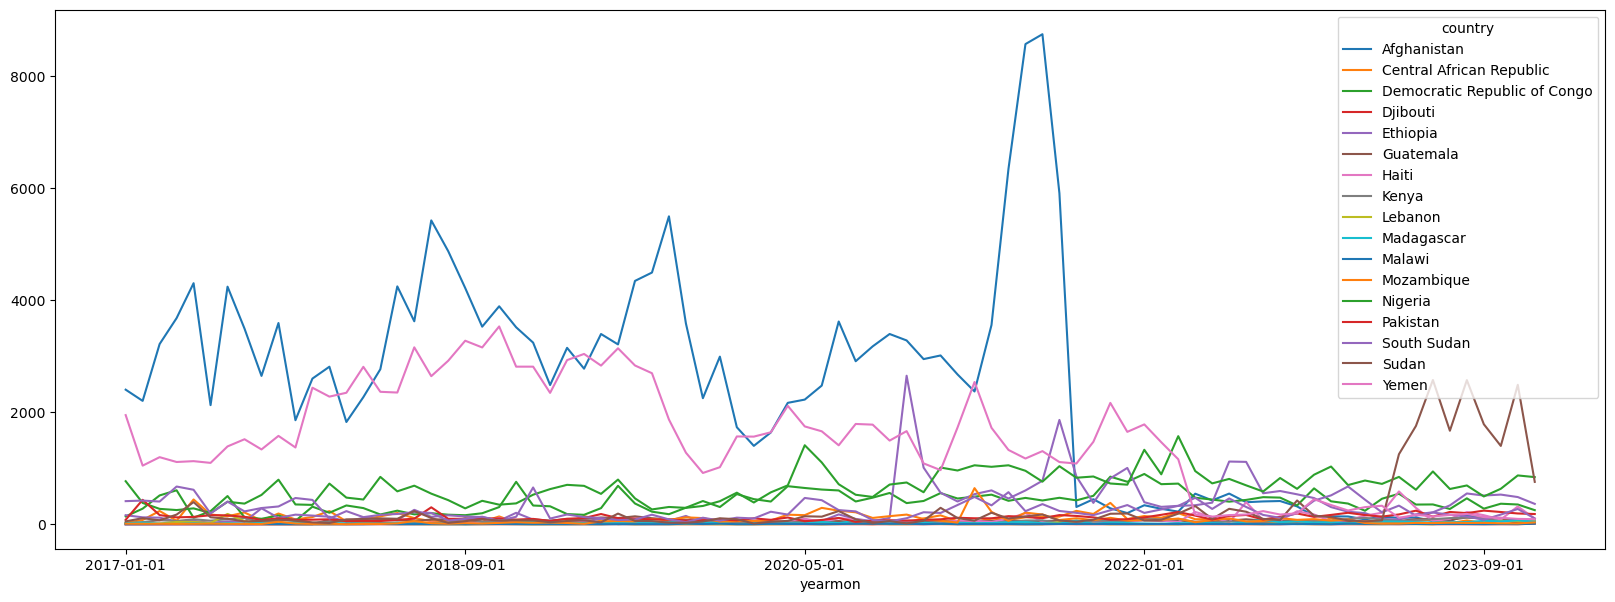

In [32]:
acled_df_final.groupby(['yearmon','country'])['fatalities_total'].sum().unstack().plot(kind = 'line', figsize = (20, 7))

In [21]:
acled_df_final.to_csv(home+'\stores\processed\conflict_df.csv')

In [33]:
def add_rolling_anomalies(df, value_col, unit_col, date_col):
    """
    Adds z-score anomalies using a 12-month rolling window per unit.

    Parameters:
    - df: input DataFrame
    - value_col: name of the column to compute anomalies on
    - unit_col: column to group by (e.g., region or location ID)
    - date_col: datetime column to sort by
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values([unit_col, date_col])

    # Compute rolling mean and std using transform (safe for alignment)
    df[f'{value_col}_rolling_mean'] = (
        df.groupby(unit_col)[value_col]
          .transform(lambda x: x.rolling(window=12, min_periods=6).mean())
    )
    df[f'{value_col}_rolling_std'] = (
        df.groupby(unit_col)[value_col]
          .transform(lambda x: x.rolling(window=12, min_periods=6).std())
    )

    # Compute z-score
    df[f'{value_col}_zscore'] = (
        (df[value_col] - df[f'{value_col}_rolling_mean']) / df[f'{value_col}_rolling_std']
    )

    # Create binary flags
    df[f'{value_col}_below_1sd'] = (df[f'{value_col}_zscore'] <= -1).astype(int)
    df[f'{value_col}_below_2sd'] = (df[f'{value_col}_zscore'] <= -2).astype(int)
    df[f'{value_col}_above_1sd'] = (df[f'{value_col}_zscore'] >= 1).astype(int)
    df[f'{value_col}_above_2sd'] = (df[f'{value_col}_zscore'] >= 2).astype(int)

    return df


In [41]:
event_cols+['fatalities_total']

['Political violence',
 'Demonstrations',
 'Strategic developments',
 'Political violence; Demonstrations',
 'fatalities_total']

In [34]:
from functools import reduce

acled_df_final_lag = acled_df_final.copy()
base_cols = ['country', 'adm1_name', 'adm2_name', 'latitude', 'longitude', 
             'yearmon', 'actor1', 'actor2', 'timestamp', 'event_id_cnty']

# This will hold minimal processed outputs to be merged later
processed_dfs = []

for target_var in event_cols+['fatalities_total']:
    # Minimal subset to avoid working on full frame
    #temp_df = acled_df_final[base_cols + [target_var]].copy()

    # Add rolling means and anomalies
    acled_df_final = add_rolling_means(acled_df_final, target_var, unit_col='adm2_name', date_col='yearmon')
    acled_df_final = add_rolling_anomalies(acled_df_final, value_col=target_var, unit_col='adm2_name', date_col='yearmon')


KeyboardInterrupt



# Load GeoDF to merge ACLED Data with geocoded

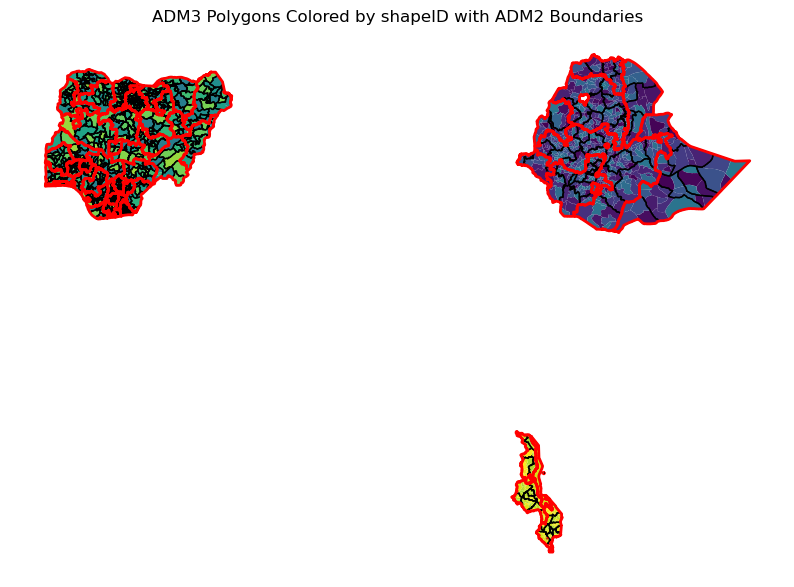

In [311]:
# Load shapefile I seperated created using goolge colab
geo_df = gpd.read_file(home+r"\stores\final_geo_df.shp")

# Create plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot ADM3 polygons filled by shapeID
geo_df.plot(
    column='shapeID', 
    cmap='viridis', 
    ax=ax, 
    edgecolor='none', 
    legend=False
)

# Overlay ADM2 boundaries
geo_df.dissolve(by='adm2_name').boundary.plot(
    ax=ax, 
    color='black', 
    linewidth=1
)

# Overlay ADM2 boundaries
geo_df.dissolve(by='adm1_name').boundary.plot(
    ax=ax, 
    color='red', 
    linewidth=2
)

# Optional cleanup
ax.set_title("ADM3 Polygons Colored by shapeID with ADM2 Boundaries", fontsize=12)
ax.set_axis_off()
plt.show()

In [71]:
load_dotenv(dotenv_path=home+r"\openai_key.env")

True

In [72]:
import openai
# Load from .env
load_dotenv(dotenv_path=home+r"\openai_key.env")
openai_key = os.getenv("openai")
openai_key

NameError: name 'geo_home' is not defined

In [465]:
# Load country_codes
with open(home+r"\stores\country_codes.json", "r") as f:
    country_map = json.load(f)
country_map

{'Afghanistan': 'AFG',
 'Bangladesh': 'BGD',
 'Pakistan': 'PAK',
 'Timor-Leste': 'TLS',
 'Burundi': 'BDI',
 'Central African Republic': 'CAF',
 'Congo, DRC': 'COD',
 'Djibouti': 'DJI',
 'Ethiopia': 'ETH',
 'Kenya': 'KEN',
 'Somalia': 'SOM',
 'South Sudan': 'SSD',
 'Sudan': 'SDN',
 'Tanzania': 'TZA',
 'Uganda': 'UGA',
 'Angola': 'AGO',
 'Eswatini': 'SWZ',
 'Lesotho': 'LSO',
 'Madagascar': 'MDG',
 'Malawi': 'MWI',
 'Mozambique': 'MOZ',
 'Namibia': 'NAM',
 'Nigeria': 'NGA',
 'South Africa': 'ZAF',
 'Zambia': 'ZMB',
 'Zimbabwe': 'ZWE',
 'Dominican Republic': 'DOM',
 'El Salvador': 'SLV',
 'Guatemala': 'GTM',
 'Haiti': 'HTI',
 'Honduras': 'HND',
 'LAC Region (tri-National)': 'LAC',
 'Lebanon': 'LBN',
 'Yemen': 'YEM'}

In [481]:
acled_df_final.to_csv(home +r'\stores\processed\acled_df_final.csv')

In [417]:
import geopandas as gpd
from shapely.geometry import Point

# Step 1: Create Point geometries from latitude and longitude
acled_df_final['geometry'] = acled_df_final.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Step 2: Convert to GeoDataFrame
acled_geo_df_final = gpd.GeoDataFrame(acled_df_final, geometry='geometry')

# Step 3: Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
acled_geo_df_final = acled_geo_df_final.set_crs(epsg=4326)

In [482]:
acled_df_final.groupby('country')['adm2_name'].nunique()

country
Ethiopia     78
Malawi       27
Nigeria     639
Name: adm2_name, dtype: int64

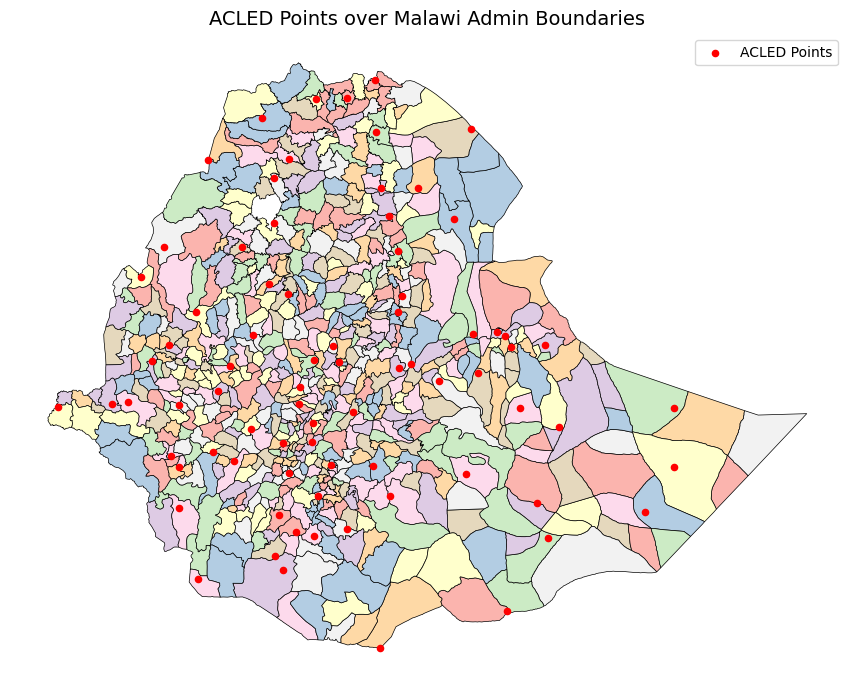

In [469]:
# Filter both GeoDataFrames for Malawi
country = 'Ethiopia'
poly = geo_df[geo_df['country'] == country_map[country]]
points = acled_geo_df_final[acled_geo_df_final['country'] == country].drop_duplicates(subset=['adm2_name'])

# Create plot
fig, ax = plt.subplots(figsize=(10, 7))

# Plot polygons (base map)
poly.plot(ax=ax, column='shapeID', cmap='Pastel1', edgecolor='black', linewidth=0.5)

# Plot points (overlaid)
points.plot(ax=ax, color='red', markersize=20, label='ACLED Points')

# Optional: Add legend and title
plt.title("ACLED Points over Malawi Admin Boundaries", fontsize=14)
plt.legend()
plt.axis('off')
plt.tight_layout()

plt.show()

In [431]:
# Ensure both GeoDataFrames have the same CRS
acled_geo_df_final = acled_geo_df_final.to_crs(geo_df.crs)

# Spatial join: match each point to the polygon it intersects
joined_df = gpd.sjoin(acled_geo_df_final, geo_df, how='left', op='intersects')

AttributeError: No geometry data set yet (expected in column 'geometry'.)

In [437]:
final_acled_geo_df = joined_df.merge(geo_df.rename(columns={'geometry': 'poly_geometry'}))
# Now replace the point geometry with polygon geometry
final_acled_geo_df['geometry'] = final_acled_geo_df['poly_geometry']
final_acled_geo_df = final_acled_geo_df.set_geometry('geometry').drop(columns=['poly_geometry', 'index_right'])

In [450]:
test_df = final_acled_geo_df.drop_duplicates(subset = ['adm1_name_left','adm2_name_left'])

In [455]:
geo_df.groupby('country')['shapeID'].nunique()

country
ETH    690
MWI    245
NGA    774
Name: shapeID, dtype: int64

In [454]:
final_acled_geo_df.groupby('country')['shapeID'].nunique()

country
ETH    339
MWI     47
NGA    647
Name: shapeID, dtype: int64

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

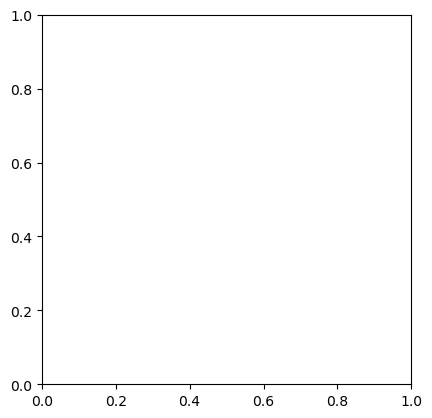

In [444]:
final_acled_geo_df.drop_duplicates(subset = ['adm1_name','adm2_name']).plot(column = 'geometry')

In [402]:
import difflib



country = 'Ethiopia'
country_match = {'Malawi':'adm2_name',
                  'Nigeria':'adm1_name',
                  'Ethiopia':'adm2_name'}



acled_adm_name = acled_df_final[acled_df_final['country']==country][country_match[country]].unique().tolist()
target_name = geo_df[geo_df['country']==country_map[country]][country_match[country]].unique().tolist()

# Creating a dictionary to match original names to the closest in new names
matched_names = {}

for name in target_name:
    closest_match = difflib.get_close_matches(name, acled_adm_name, n=1, cutoff=0.80)
    if closest_match:
        matched_names[name] = closest_match[0]
    else:
        matched_names[name] = None

unmatched = {k for k, v in matched_names.items() if v is None}

# Left is Target Geo DF and right is ACLED Name
print('# of target names (GEODF): ', len(target_name), '\n',
      '# of acled names (Acled): ', len(acled_adm_name), '\n',
      '# of matched names (Matched Names): ', len(matched_names) - len(unmatched), '\n')

sorted_dict = dict(sorted(matched_names.items()))
sorted_dict

# of target names (GEODF):  74 
 # of acled names (Acled):  78 
 # of matched names (Matched Names):  46 



{'Afder': 'Afder',
 'Agnuak': None,
 'Alaba': None,
 'Arsi': 'Arsi',
 'Asosa': 'Asosa',
 'Awi/Agew': None,
 'Bale': 'Bale',
 'Basketo': None,
 'Bench Maji': None,
 'Borena': 'Borena',
 'Central': None,
 'Dawro': None,
 'Dire Dawa': None,
 'Doolo': 'Doolo',
 'East Gojam': 'East Gojam',
 'East Harerge': 'East Hararge',
 'East Shewa': 'East Shewa',
 'East Wellega': 'East Wellega',
 'Eastern': None,
 'Fafan': 'Fafan',
 'Gamo Gofa': None,
 'Gedio': 'Gedeo',
 'Guji': 'Guji',
 'Gurage': 'Guraghe',
 'Hadiya': 'Hadiya',
 'Hareri': 'Harari',
 'Horo Guduru': None,
 'Ilubabor': None,
 'Jarar': 'Jarar',
 'Jimma': 'Jimma',
 'KT': None,
 'Keffa': 'Kefa',
 'Kelem Wellega': 'Kellem Wollega',
 'Kemashi': 'Kemashi',
 'Konta': None,
 'Korahe': 'Korahe',
 'Liben': 'Liban',
 'Majang': None,
 'Metekel': 'Metekel',
 'Nogob': 'Nogob',
 'North Gonder': 'North Gondar',
 'North Shewa(R3)': 'North Shewa',
 'North Shewa(R4)': 'North Shewa',
 'North Western': None,
 'North Wollo': 'North Wello',
 'Nuer': 'Nuwer',
 '

In [404]:
# Unmatched Target Names
print('Unmatched Target Names(from GeoDF):', sorted(unmatched), '\n')
print('ACLED names:', sorted(acled_adm_name))

Unmatched Target Names(from GeoDF): ['Agnuak', 'Alaba', 'Awi/Agew', 'Basketo', 'Bench Maji', 'Central', 'Dawro', 'Dire Dawa', 'Eastern', 'Gamo Gofa', 'Horo Guduru', 'Ilubabor', 'KT', 'Konta', 'Majang', 'North Western', "Segen Peoples'", 'Selti', 'Southern', 'Special Woreda', 'Wag Himra', 'Western', 'Yem', 'Zone 1', 'Zone 2', 'Zone 3', 'Zone 4', 'Zone 5'] 

ACLED names: ['Afder', 'Agnewak', 'Amaro', 'Arsi', 'Asosa', 'Awi', 'Awsi-Zone 1', 'Bale', 'Bench Sheko', 'Borena', 'Buno Bedele', 'Central Gondar', 'Central Tigray', 'Daawa', 'Dire Dawa rural', 'Dire Dawa urban', 'Doolo', 'East Bale', 'East Gojam', 'East Hararge', 'East Shewa', 'East Wellega', 'Eastern Tigray', 'Erer', 'Fafan', 'Fanti-Zone 4', 'Finfine Special', 'Gabi-Zone 3', 'Gamo', 'Gedeo', 'Guji', 'Guraghe', 'Hadiya', 'Halaba', 'Harari', 'Horo Gudru Wellega', 'Ilu Aba Bora', 'Itang Special woreda', 'Jarar', 'Jimma', 'Kefa', 'Kellem Wollega', 'Kemashi', 'Kilbati-Zone 2', 'Konso', 'Konta Special', 'Korahe', 'Liban', 'Mekelle Tigray

In [408]:
# Replace with your OpenAI key
openai.api_key = openai_key

# Format dictionary for review
dict_text = json.dumps(matched_names, indent=2)

# Prompt for matching
prompt = (
    "You are a helpful assistant.\n"
    "Below is a list of known correct district names:\n"
    f"{acled_adm_name}\n\n"
    "Please match each of the following unmatched district names to the most similar correct name "
    "from the list above, if a close match exists. If a match cannot be confidently found, return null.\n\n"
    f"Unmatched district names:\n{unmatched}\n\n"
    "Return your answer as a JSON dictionary where the keys are the unmatched names, and the values are either the matched correct names or null. "
    "Output only the dictionary, with no additional explanation or formatting."
)


# Call OpenAI API
response = openai.ChatCompletion.create(
    model="gpt-4",
    messages=[{"role": "user", "content": prompt}],
    temperature=0
)



In [409]:
import ast

content = response.choices[0].message["content"]

# Step 1: Strip outer quotes if present
if content.startswith("'") and content.endswith("'"):
    content = content[1:-1]
content = content.replace("null", "None")

# Step 2: Use ast.literal_eval to safely parse
try:
    matches = ast.literal_eval(content)
    print("✅ Parsed entries:")
    print(matches)
except Exception as e:
    print("⚠️ Failed to parse response as dictionary.")
    print("Raw output:\n", content)


✅ Parsed entries:
{'Western': 'Western Tigray', 'Wag Himra': None, 'Zone 1': 'Awsi-Zone 1', 'Horo Guduru': 'Horo Gudru Wellega', 'Dawro': None, 'Ilubabor': None, 'Agnuak': 'Agnewak', 'Majang': None, 'Gamo Gofa': 'Gamo', 'Basketo': None, 'Zone 5': None, 'Central': 'Central Gondar', 'KT': None, 'Zone 4': 'Fanti-Zone 4', 'Special Woreda': 'Itang Special woreda', 'Zone 3': 'Gabi-Zone 3', 'Southern': 'Southern Tigray', "Segen Peoples'": None, 'Selti': 'Siltie', 'Yem': None, 'Awi/Agew': 'Awi', 'Bench Maji': 'Bench Sheko', 'North Western': 'North Western Tigray', 'Eastern': 'Eastern Tigray', 'Konta': 'Konta Special', 'Zone 2': 'Kilbati-Zone 2', 'Alaba': 'Halaba', 'Dire Dawa': 'Dire Dawa urban'}


In [413]:
gpt_unmatched = {k for k, v in matches.items() if v is None}
print('GPT-Unmatched Target Names(from GeoDF):', sorted(gpt_unmatched), '\n')
print('ACLED names:', sorted(acled_adm_name))

GPT-Unmatched Target Names(from GeoDF): ['Basketo', 'Dawro', 'Ilubabor', 'KT', 'Majang', "Segen Peoples'", 'Wag Himra', 'Yem', 'Zone 5'] 

ACLED names: ['Afder', 'Agnewak', 'Amaro', 'Arsi', 'Asosa', 'Awi', 'Awsi-Zone 1', 'Bale', 'Bench Sheko', 'Borena', 'Buno Bedele', 'Central Gondar', 'Central Tigray', 'Daawa', 'Dire Dawa rural', 'Dire Dawa urban', 'Doolo', 'East Bale', 'East Gojam', 'East Hararge', 'East Shewa', 'East Wellega', 'Eastern Tigray', 'Erer', 'Fafan', 'Fanti-Zone 4', 'Finfine Special', 'Gabi-Zone 3', 'Gamo', 'Gedeo', 'Guji', 'Guraghe', 'Hadiya', 'Halaba', 'Harari', 'Horo Gudru Wellega', 'Ilu Aba Bora', 'Itang Special woreda', 'Jarar', 'Jimma', 'Kefa', 'Kellem Wollega', 'Kemashi', 'Kilbati-Zone 2', 'Konso', 'Konta Special', 'Korahe', 'Liban', 'Mekelle Tigray', 'Metekel', 'Mirab Omo', 'Nogob', 'North Gondar', 'North Shewa', 'North Wello', 'North Western Tigray', 'Nuwer', 'Oromia', 'Region 14', 'Shabelle', 'Sheka', 'Sidama', 'Siltie', 'Siti', 'South Gondar', 'South Omo', 'Sou

In [378]:
# Update only non-null entries from matched_names2 into matched_names
for key, value in matches.items():
    if value is not None:
        matched_names[key] = value
matched_names

{'Chitipa': 'Chitipa',
 'Mangochi': 'Mangochi',
 'Dedza': 'Dedza',
 'Salima': 'Salima',
 'Nkhotakota': 'Nkhotakota',
 'Nkhata Bay': 'Nkhata Bay',
 'Rumphi': 'Rumphi',
 'Karonga': 'Karonga',
 'Area under National Administration': None,
 'Phalombe': None,
 'Zomba': 'Zomba City',
 'Mulanje': 'Mulanje',
 'Thyolo': 'Thyolo',
 'Mzimba': 'Mzimba',
 'Kasungu': 'Kasungu',
 'Ntchisi': None,
 'Dowa': 'Dowa',
 'Mchinji': 'Mchinji',
 'Lilongwe': 'Lilongwe',
 'Ntcheu': 'Ntcheu',
 'Machinga': 'Machinga',
 'Balaka': 'Balaka',
 'Neno': 'Neno',
 'Mwanza': 'Mwanza',
 'Chiradzulu': 'Chiradzulu',
 'Blantyre': 'Blantyre',
 'Chikwawa': 'Chikwawa',
 'Nsanje': 'Nsanje',
 'Likoma': None}

In [379]:
mwi_matched_names = matched_names.copy()

In [364]:
nga_matched_names = matched_names.copy()

In [365]:
nga_matched_names

{'Akwa Ibom': 'Akwa Ibom',
 'Bayelsa': 'Bayelsa',
 'Rivers': 'Rivers',
 'Cross River': 'Cross River',
 'Oyo': 'Oyo',
 'Ogun': 'Ogun',
 'Ondo': 'Ondo',
 'Delta': 'Delta',
 'Taraba': 'Taraba',
 'Adamawa': 'Adamawa',
 'Osun': 'Osun',
 'Enugu': 'Enugu',
 'Ebonyi': 'Ebonyi',
 'Kwara': 'Kwara',
 'Kogi': 'Kogi',
 'Yobe': 'Yobe',
 'Abuja': 'Federal Capital Territory',
 'Zamfara': 'Zamfara',
 'Kano': 'Kano',
 'Kebbi': 'Kebbi',
 'Sokoto': 'Sokoto',
 'Jigawa': 'Jigawa',
 'Bauchi': 'Bauchi',
 'Edo': 'Edo',
 'Kaduna': 'Kaduna',
 'Katsina': 'Katsina',
 'Borno': 'Borno',
 'Gombe': 'Gombe',
 'Lagos': 'Lagos',
 'Niger': 'Niger',
 'Ekiti': 'Ekiti',
 'Anambra': 'Anambra',
 'Benue': 'Benue',
 'Abia': 'Abia',
 'Imo': 'Imo',
 'Nassarawa': 'Nassarawa',
 'Plateau': 'Plateau'}

In [301]:
import ast  # safer than eval for trusted literal input

content = response.choices[0].message["content"]

try:
    suspicious_matches = ast.literal_eval(content)
    print("✅ Parsed suspicious entries:")
    print(suspicious_matches)
except Exception as e:
    print("⚠️ Failed to parse response as dictionary.")
    print("Raw output:\n", content)

✅ Parsed suspicious entries:
{'Abuja': 'Federal Capital Territory'}


In [302]:
suspicious_matches

{'Abuja': 'Federal Capital Territory'}

In [287]:
unmatched = {k for k, v in content.items() if v is null}

AttributeError: 'str' object has no attribute 'items'

In [288]:
content

'{\n  "Eastern Obolo": "Eastern Obolo",\n  "Ekeremor": "Ekermor",\n  "Degema": "Degema",\n  "Andoni": "Andoni",\n  "Akpabuyo": "Akpabuyo",\n  "Oron": "Oron",\n  "Calabar Municipal": "Calabar Municipal",\n  "Udung Uko": "Udung Uko",\n  "Southern Ijaw": "Southern Ijaw",\n  "Iwajowa": null,\n  "Ibarapa North": "Ibarapa North",\n  "Bonny": "Bonny",\n  "Imeko-Afon": "Imeko-Afon",\n  "Ibeno": "Ibeno",\n  "Nembe": "Nembe",\n  "Ilaje": "Ilaje",\n  "Brass": "Brass",\n  "Warri North": "Warri North",\n  "Ese-Odo": "Ese-Edo",\n  "Ardo-Kola": "Ardo Kola",\n  "Burutu": "Burutu",\n  "Gombi": "Gombi",\n  "Yorro": "Yorro",\n  "Yola North": "Yola-North",\n  "Demsa": "Demsa",\n  "Mbo": "Mbo",\n  "Lau": "Lau",\n  "Ibarapa Central": "Ibarapa Central",\n  "Abeokuta North": "Abeokuta North",\n  "Warri South-West": "Warri South-West",\n  "Warri South": "Warri South",\n  "Isokan": "Isokan",\n  "Irewole": null,\n  "Essien Udim": "Essien Udim",\n  "Onna": "Onna",\n  "Udenu": "Udenu",\n  "Enugu South": "Enugu Sou

In [286]:
print(content)

{
  "Eastern Obolo": "Eastern Obolo",
  "Ekeremor": "Ekermor",
  "Degema": "Degema",
  "Andoni": "Andoni",
  "Akpabuyo": "Akpabuyo",
  "Oron": "Oron",
  "Calabar Municipal": "Calabar Municipal",
  "Udung Uko": "Udung Uko",
  "Southern Ijaw": "Southern Ijaw",
  "Iwajowa": null,
  "Ibarapa North": "Ibarapa North",
  "Bonny": "Bonny",
  "Imeko-Afon": "Imeko-Afon",
  "Ibeno": "Ibeno",
  "Nembe": "Nembe",
  "Ilaje": "Ilaje",
  "Brass": "Brass",
  "Warri North": "Warri North",
  "Ese-Odo": "Ese-Edo",
  "Ardo-Kola": "Ardo Kola",
  "Burutu": "Burutu",
  "Gombi": "Gombi",
  "Yorro": "Yorro",
  "Yola North": "Yola-North",
  "Demsa": "Demsa",
  "Mbo": "Mbo",
  "Lau": "Lau",
  "Ibarapa Central": "Ibarapa Central",
  "Abeokuta North": "Abeokuta North",
  "Warri South-West": "Warri South-West",
  "Warri South": "Warri South",
  "Isokan": "Isokan",
  "Irewole": null,
  "Essien Udim": "Essien Udim",
  "Onna": "Onna",
  "Udenu": "Udenu",
  "Enugu South": "Enugu South",
  "Ikot Ekpene": "Ikot Ekpene",
 

In [33]:
# Filter unique rows
acled_geo_df = acled_df_final[acled_df_final['country']=='Malawi']

# Create geometry from latitude and longitude
acled_geo_df['geometry'] = acled_geo_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to GeoDataFrame
acled_geo_df = gpd.GeoDataFrame(acled_geo_df, geometry='geometry', crs="EPSG:4326")

C:\Users\ck24\AppData\Local\Temp\ipykernel_56560\1858497454.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acled_geo_df['geometry'] = acled_geo_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)


In [34]:
sjoin_to_find_closest = gpd.sjoin(geo_df[geo_df['shapeName'].isin(unmatched)], acled_geo_df[['geometry','adm2_name']], how = 'left', op='within')
sjoin_to_find_closest['adm2_name_right'].values.tolist()

[]

# Earth Observation

In [220]:
# Set directory
directory = os.path.join(home, 'stores', 'processed')
csv_files = glob.glob(os.path.join(directory, '*.csv'))[:-1]

# Base merge columns
base_var = ['country', 'shapeGroup', 'shapeID', 'shapeName', 'shapeType', 'year', 'month']

# Initialize final merged DataFrame
merged_df = None

for f in csv_files:
    subdf = pd.read_csv(f).rename(columns={'admin1': 'adm1_name', 'admin2': 'adm2_name'})
    var_name = f.split('\\')[-1].split('_')[0]

    if 'mean' in subdf.columns:
        # Keep only base_var and the renamed mean column
        subdf = subdf[base_var + ['mean']].copy()
        subdf = subdf.rename(columns={'mean': var_name})
    else:
        print(f"{var_name}: no 'mean' column found, keeping all columns.")
        # Optionally, rename the columns to avoid collisions
        subdf.columns = [f"{col}" if col not in base_var else col for col in subdf.columns]

    # Merge
    if merged_df is None:
        merged_df = subdf
    else:
        merged_df = pd.merge(merged_df, subdf, on=base_var, how='outer')

# Add year_month datetime column
merged_df['year_month'] = pd.to_datetime(merged_df[['year', 'month']].assign(day=1))

# Result
merged_df


modis: no 'mean' column found, keeping all columns.


,country,shapeGroup,shapeID,shapeName,shapeType,year,month,evi,Clear_day_cov,Clear_night_cov,...,QC_Night,adm1_name,adm2_name,orig_area,shapeISO,chunk,ndvi,prep,spei,year_month
0,NGA,NGA,59680162B74485110483501,Itesiwaju,ADM2,2000,2,1861.330711,2652.672552,2427.111467,...,32.463801,Oyo,Itesiwaju,0.141101,NaN,3.0,3769.818698,0.000000,-1.525220,2000-02-01
1,NGA,NGA,59680162B64506251287847,Kajola,ADM2,2000,2,1774.918640,2230.995214,2221.192056,...,22.961167,Oyo,Kajola,0.052184,NaN,3.0,3396.179624,0.083779,-1.543684,2000-02-01
2,NGA,NGA,59680162B79793295224635,Nkanu West,ADM2,2000,2,2448.518874,2122.965545,2364.561166,...,8.219748,Enugu,Nkanu West,0.018985,NaN,3.0,3985.372782,0.000501,-2.554383,2000-02-01
3,NGA,NGA,59680162B68024378624756,Afikpo North,ADM2,2000,2,2490.943650,1948.249526,2092.477818,...,6.621469,Ebonyi,Afikpo North,0.021232,NaN,3.0,4125.016288,0.213264,-2.708020,2000-02-01
4,NGA,NGA,59680162B72688070781247,Donga,ADM2,2000,2,1769.378908,1981.130209,2165.094470,...,18.872296,Taraba,Donga,0.253396,NaN,3.0,3378.689578,0.000080,-0.841383,2000-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430663,ETH,ETH,50319843B5964560944788,Esira,ADM3,2000,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.293382,-1.918636,2000-01-01
430664,ETH,ETH,50319843B99173318035572,Sodo Zuria,ADM3,2000,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.314417,-1.190357,2000-01-01
430665,ETH,ETH,50319843B32669148569770,Loka Abaya,ADM3,2000,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335865,-1.344204,2000-01-01
430666,ETH,ETH,50319843B33186421674041,Arbe Gonna,ADM3,2000,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.404883,-1.639279,2000-01-01


In [221]:
def convert_modis_lst_to_celsius(lst_array):
    """
    Convert MODIS LST (e.g., LST_Day_1km or LST_Night_1km) to Celsius.
    
    Parameters:
    -----------
    lst_array : np.ndarray
        Input array containing raw MODIS LST values (scaled integers).

    Returns:
    --------
    np.ndarray
        Array of temperature in Celsius with invalid values masked as np.nan.
    """
    # Initialize output array with NaNs
    lst_celsius = np.full_like(lst_array, np.nan, dtype=np.float32)

    # Define valid range (exclude fill values: 0, 32767)
    valid = (lst_array > 7500) & (lst_array < 65535)

    # Apply conversion: scale factor 0.02, convert to Celsius
    lst_celsius[valid] = (lst_array[valid] * 0.02) - 273.15

    return lst_celsius

In [222]:
merged_df['daytime_temp_C'] = convert_modis_lst_to_celsius(merged_df['LST_Day_1km'])
merged_df['nighttime_temp_C'] = convert_modis_lst_to_celsius(merged_df['LST_Night_1km'])

In [237]:
var = ['evi', 'prep', 'spei', 'daytime_temp_C', 'nighttime_temp_C', 'ndvi']
v = var[4]
print(v)

# Step 2: Compute the group means
group_means = merged_df.groupby(['country', 'shapeID', 'year_month'])[v].mean()
print(group_means.head())

# Step 3: Filter for NaN group means
nan_groups = group_means[group_means.isna()]
nan_index = nan_groups.index

# Step 4: Safely filter original DataFrame
if len(nan_index) == 0:
    print(f"No NaN group means found for variable '{v}'")
    filtered_nan_df = pd.DataFrame()  # or `None`, depending on your use case
else:
    filtered_nan_df = merged_df.set_index(['country', 'shapeID', 'year_month']).loc[nan_index].reset_index()
    print(set(filtered_nan_df['year_month'].unique()))




nighttime_temp_C
country  shapeID                  year_month
ETH      50319843B10181001606973  2000-01-01          NaN
                                  2000-02-01    10.024131
                                  2000-03-01    11.576074
                                  2000-04-01    10.642961
                                  2000-05-01    11.542057
Name: nighttime_temp_C, dtype: float32
{numpy.datetime64('2000-01-01T00:00:00.000000000'), numpy.datetime64('2012-07-01T00:00:00.000000000'), numpy.datetime64('2004-09-01T00:00:00.000000000'), numpy.datetime64('2002-07-01T00:00:00.000000000'), numpy.datetime64('2003-06-01T00:00:00.000000000'), numpy.datetime64('2006-07-01T00:00:00.000000000'), numpy.datetime64('2008-06-01T00:00:00.000000000'), numpy.datetime64('2009-07-01T00:00:00.000000000'), numpy.datetime64('2013-07-01T00:00:00.000000000'), numpy.datetime64('2013-08-01T00:00:00.000000000'), numpy.datetime64('2015-07-01T00:00:00.000000000'), numpy.datetime64('2007-12-01T00:00:00.000000000

<AxesSubplot:xlabel='year_month'>

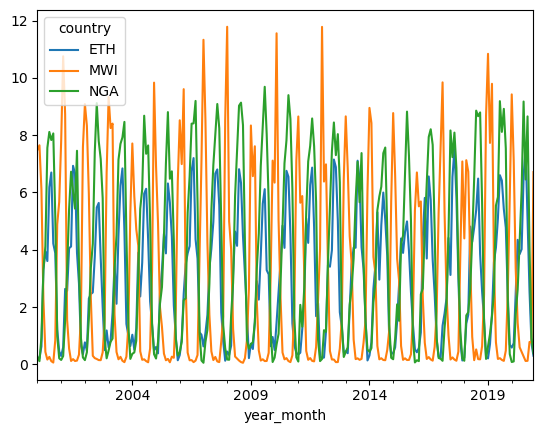

In [238]:
merged_df.groupby(['year_month','country'])['prep'].mean().unstack().plot()

In [239]:
for target_var in ['evi','prep','spei','daytime_temp_C','nighttime_temp_C','ndvi']:
    # Minimal subset to avoid working on full frame
    #temp_df = acled_df_final[base_cols + [target_var]].copy()

    # Add rolling means and anomalies
    merged_df = add_rolling_means(merged_df, target_var, unit_col='shapeID', date_col='year_month')
    merged_df = add_rolling_anomalies(merged_df, value_col=target_var, unit_col='shapeID', date_col='year_month')

In [241]:
merged_df[['adm1_name','adm2_name','shapeID','year_month','evi','prep','spei','daytime_temp_C','nighttime_temp_C','ndvi']].sort_values(by = ['shapeID','year_month'])

,adm1_name,adm2_name,shapeID,year_month,evi,prep,spei,daytime_temp_C,nighttime_temp_C,ndvi
430154,NaN,NaN,50319843B10181001606973,2000-01-01,NaN,0.377144,-1.994046,NaN,NaN,NaN
1095,Amhara,Awi/Agew,50319843B10181001606973,2000-02-01,1853.319705,0.443310,-2.119421,39.504059,10.024131,3240.030335
2704,Amhara,Awi/Agew,50319843B10181001606973,2000-03-01,1820.230356,0.630155,-2.826889,41.002243,11.576074,3153.454100
4513,Amhara,Awi/Agew,50319843B10181001606973,2000-04-01,2115.981430,4.235997,0.574230,36.571548,10.642961,3683.903114
6122,Amhara,Awi/Agew,50319843B10181001606973,2000-05-01,2788.167988,4.215821,1.724212,29.792994,11.542057,4919.648325
...,...,...,...,...,...,...,...,...,...,...
420779,Southern Region,Machinga,60268647B9941577632844,2020-08-01,1712.293298,0.186646,0.446794,32.618271,16.147442,3364.178403
422188,Southern Region,Machinga,60268647B9941577632844,2020-09-01,1505.976698,0.108702,-0.350162,38.813812,19.187721,2967.087913
424197,Southern Region,Machinga,60268647B9941577632844,2020-10-01,1497.665676,0.542131,-0.371966,43.937298,21.205036,2812.747445
425906,Southern Region,Machinga,60268647B9941577632844,2020-11-01,1585.466208,0.597571,-1.746806,45.309235,23.462261,2796.210453


1. merge merged_df with geo_df
2. merge ACLEAD with GEO_DF by ADM2 Name
3. Merge Price with GEO_DF by ADM2 Name

4. Link final data with LSMS Run regression

<AxesSubplot:>

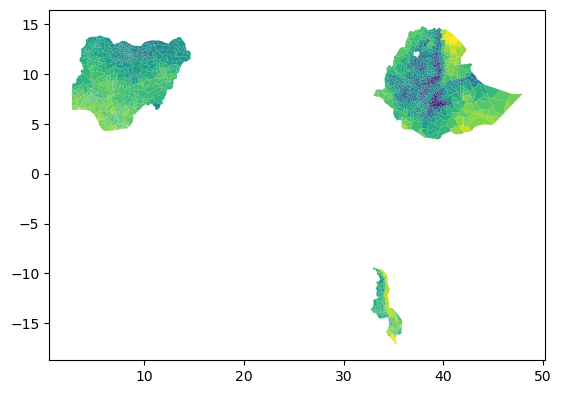

In [264]:
eo_geo_df = geo_df.merge(merged_df[['adm1_name','adm2_name','shapeID','year_month','evi','prep','spei','daytime_temp_C','nighttime_temp_C','ndvi']], on = ['shapeID','adm1_name','adm2_name'])
type(eo_geo_df)

eo_geo_df.drop_duplicates(subset = ['shapeID'], keep = 'last').plot(column = 'nighttime_temp_C')

In [484]:
eo_geo_df.to_csv(home +r'\stores\processed\eo_geo_df.csv')